<a href="https://colab.research.google.com/github/envomp/2020-Text-Mining/blob/master/week2/Quantitative_measures_of_text_complexity_for_the_Independence_Day_speeches_of_the_Presidents_of_the_Republic_of_Estonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install conllu estnltk==1.6.7b0

Esmalt loeb failid listi ning viib nad paremini käideltatavale kujule

In [47]:
from estnltk import Text
from html import unescape
import re

sample_data = [
    ("Kersti Kaljuraid", ["2020.txt", "2019.txt", "2018.txt"]),
    ("Toomas Hendrik Ilves", ["2016.txt", "2015.txt", "2014.txt"]),
    ("Arnold Rüütel", ["2006.txt", "2005.txt", "2004.txt"]),
    ("Lennart Meri", ["2001.txt", "2000.txt", "1999.txt"])
]

def formatted_data(filename):
  return open(filename, "r").read()

texts = [
    (
      name, 
      Text("\n\n\n".join([formatted_data(filename) for filename in filenames])).analyse('all')
    ) for name, filenames in sample_data
]


 Flesch Reading Ease Score(FRES) skoor

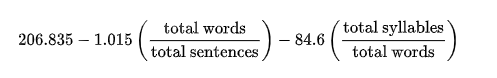

In [48]:
def count_syllables(word: str) -> int:
    syllable_count = 0
    vowels = "aeiouõäöü"
    if word[0] in vowels:
        syllable_count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            syllable_count += 1
    if syllable_count == 0:
        syllable_count += 1
    return syllable_count

In [49]:
def get_fres(words, sentences):
  syllables = sum([count_syllables(x.root) for x in words])
  return round(206.835 - 1.015 * len(words) / sentences - 84.6 * syllables / len(words), 2)

Gunning FOG:

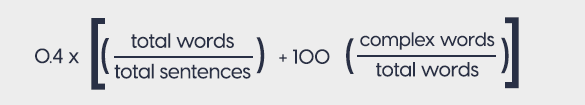

- Keerulised sõnad koosnevad kolmest või enamast silbist
- Loendatakse vaid sõnatüve silpe
- Liitsõna loetaks keeruliseks, kui vähemalt üks selle osa on kolmesilbiline
- Keerukaks ei loeta nimesid ja lühendeid

In [50]:
def get_gunning_fog(words, sentences):
  difficult_words = sum([max([count_syllables(word) for word in x.root_tokens]) >= 3 for x in words])
  return round(0.4 * len(words) / sentences + 100 * difficult_words / len(words), 2)


Leksikaalne tihedus:

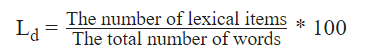

In [51]:
def get_lexical_density(words):
  content_words = []
  for word in words:
    if set(word.partofspeech) & set(['A', 'C', 'U', 'V', 'S']):
      content_words.append(word)
  return round(100 * len(content_words) / len(words), 2)

F-indeks - näitab teksti formaalsust

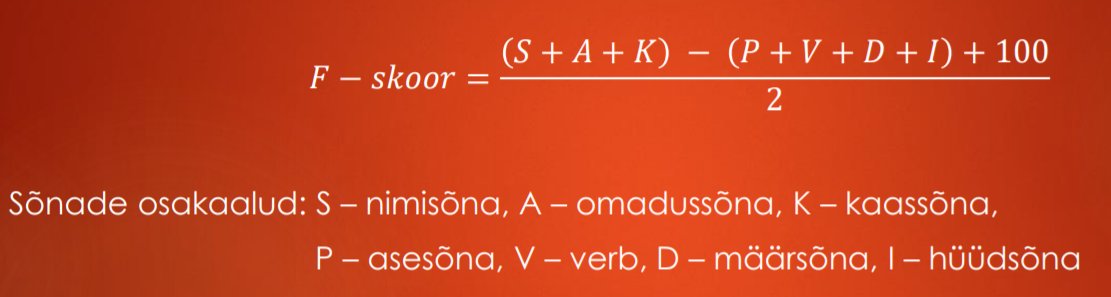

In [52]:
def get_formality(words):
  running_score = 0
  for word in words:
    if set(word.partofspeech) & set(['S', 'A', 'C', 'U', 'K']):
      running_score += 1
    elif set(word.partofspeech) & set(['P', 'V', 'D', 'I']):
      running_score -= 1
  return round((100 + running_score) / 2, 2)

Teeb listid tulemuste jaoks

In [53]:
fres_results = []
gfog_results = []
density_results = []
formality_results = []

Analüüsib tervik tekste

In [54]:
for president, text in texts:
  a = get_fres(text.words, len(text.sentences))
  b = get_gunning_fog(text.words, len(text.sentences))
  fres_results.append(a)
  gfog_results.append(b)
  print(f"president: {president} - FRES: {a}")
  print(f"president: {president} - Gunning FOG: {b}")
  print()

president: Kersti Kaljuraid - FRES: 107.0
president: Kersti Kaljuraid - Gunning FOG: 6.0

president: Toomas Hendrik Ilves - FRES: 108.6
president: Toomas Hendrik Ilves - Gunning FOG: 5.37

president: Arnold Rüütel - FRES: 105.99
president: Arnold Rüütel - Gunning FOG: 6.4

president: Lennart Meri - FRES: 106.88
president: Lennart Meri - Gunning FOG: 6.05



Rüütli tekst oli kõige keerulisem aru saadav.

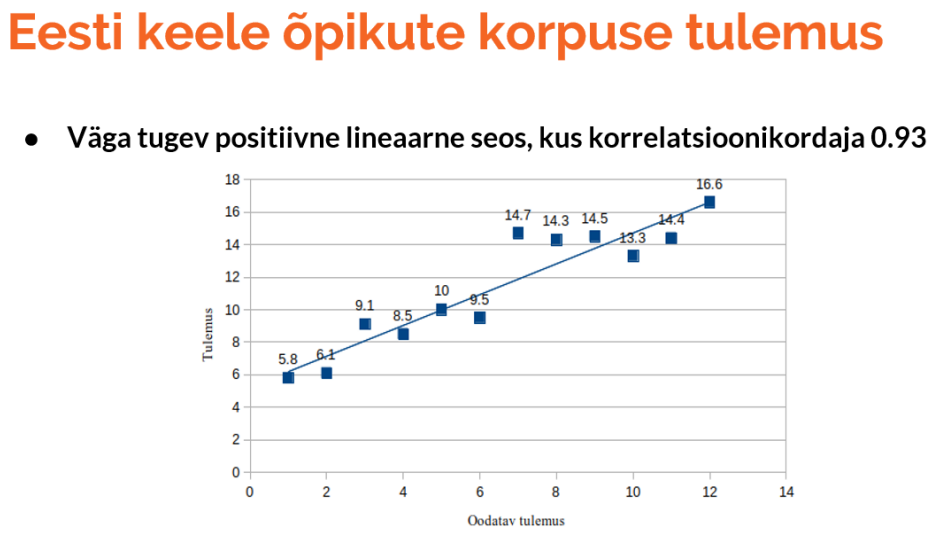

Otsib järgnevalt kõige raskemini ja kergemini loetavad laused iga presidendi jaoks:

Vaatleb presidentide leksikaalseid tihedusi

In [55]:
for president, text in texts:
  a = get_lexical_density(text.words)
  density_results.append(a)
  print(f"president: {president} - lexical density: {a}")
  print()


president: Kersti Kaljuraid - lexical density: 48.65

president: Toomas Hendrik Ilves - lexical density: 47.15

president: Arnold Rüütel - lexical density: 55.86

president: Lennart Meri - lexical density: 51.5



Tuleb välja, et Rüütli tekst oli küige informatiivsem

Vaatleb F-skoori

In [56]:
for president, text in texts:
  a = get_formality(text.words)
  formality_results.append(a)
  print(f"president: {president} - F-index: {a}")
  print()

president: Kersti Kaljuraid - F-index: -198.0

president: Toomas Hendrik Ilves - F-index: -222.5

president: Arnold Rüütel - F-index: 342.0

president: Lennart Meri - F-index: 138.0



Tuleb välja, et ka Rüütli tekst on kõige formaalsem

In [57]:
import heapq
for president, text in texts:
  gfog = []
  fres = []
 
  for sentence in text.sentences:
    try:
      if len(sentence) > 2: # Skip junk
        heapq.heappush(gfog, (get_gunning_fog(sentence, 1), sentence))
        heapq.heappush(fres, (get_fres(sentence, 1), sentence))
    except Exception:
      pass
  
  def get_n_of_side_from_heap_for_president_in_stdout(n, president, heap, heap_type, operation, operation_name):
    print(f"presidendi {president} jaoks {n} {operation_name} lauset {heap_type}'i järgi on:")
    print()
    for i, (_, sentence) in enumerate(operation(n, heap)):
      print(" ".join(sentence.text))
    print()
    print()
 
  get_n_of_side_from_heap_for_president_in_stdout(5, president, gfog, "Gunning FOG", heapq.nlargest, "kõige raskemat")
  get_n_of_side_from_heap_for_president_in_stdout(5, president, gfog, "Gunning FOG", heapq.nsmallest, "kõige lihtsamat")
  get_n_of_side_from_heap_for_president_in_stdout(5, president, fres, "FRES", heapq.nsmallest, "kõige raskemat")
  get_n_of_side_from_heap_for_president_in_stdout(5, president, fres, "FRES", heapq.nlargest, "kõige lihtsamat")
  print()
  print()

presidendi Kersti Kaljuraid jaoks 5 kõige raskemat lauset Gunning FOG'i järgi on:

Nõudlik rahulolematus ja samas usk , et homne päev on tänasest parem , kui kõvasti tööd teeme – see oli siis ja on praegugi võti , mis avab ukse me paremasse tulevikku ja aitab seletada kiiret arengut viimase veerandsajandi jooksul , mil me oleme jälle saanud ise oma maal otsustada .
Ma loodan , et rahaliste võimaluste ja antud lubaduste tasakaalustamise tunnil – ja see tund tuleb eredas märtsipäikeses , mil valimiste võitja hakkab kokku panema uut valitsust – saaks tõrjutud needki varjud , mis täna ei lase Eestil veel olla päriselt meie unistuste riik .
Riigi väärikusele mõjub laastavalt , kui kohalik omavalitsus , kelle vahetu kohus ligimese märkamine meie seaduste järgi just ongi , ei võta vastutust oma inimeste eest raskel hetkel , ei aita seista inimeste väärikuse eest , olles parematel aegadel võtnud vastu nende maksud .
Täna on siin saalis kutsutute hulgas omastehooldajaid , lastemajade töötajaid 

In [58]:
import heapq
for president, text in texts:
  density = []

  for sentence in text.sentences:
    try:
      if len(sentence) > 2: # Skip junk
        heapq.heappush(density, (get_lexical_density(sentence), sentence))
    except Exception:
      pass
  
  def get_n_of_side_from_heap_for_president_in_stdout(n, president, heap, operation, operation_name):
    print(f"presidendi {president} jaoks {n} {operation_name} lauset järgi on:")
    print()
    for i, (_, sentence) in enumerate(operation(n, heap)):
      print(" ".join(sentence.text))
    print()
    print()
 
  get_n_of_side_from_heap_for_president_in_stdout(5, president, density, heapq.nlargest, "kõige informatiivsemat")
  get_n_of_side_from_heap_for_president_in_stdout(5, president, density, heapq.nsmallest, "kõige vähem informatiivsemat")
  print()
  print()

presidendi Kersti Kaljuraid jaoks 5 kõige informatiivsemat lauset järgi on:

Positiivne tuntus on oluline julgeolekut kasvatav mõõde .
Vihastest sõnadest võib sündida ühiskonda vapustavaid tegusid .
Õmblusteta ühiskond sünnib juhtide tarkusest .
valge lume sadaden läks koju ,
Valu astel ooperist läks koju ,


presidendi Kersti Kaljuraid jaoks 5 kõige vähem informatiivsemat lauset järgi on:

Karujäntsist kõrgemale end .
Aga mis Pearudel sellest .
Eestis või kaugemal .
Küllap ta varsti jälle ulatub , aga praegu mitte .
Rootsi aga vastavalt 1995. aastal koguni 3,1% .




presidendi Toomas Hendrik Ilves jaoks 5 kõige informatiivsemat lauset järgi on:

Liitlasvägede tulek alliansi piiririikidesse on vastus uuele reaalsusele .
Kaasaegne lähenemine on laiendanud Tõe mõistet .
Veel ei ohusta juhita autod autojuhtide töökohti .
Tervise hoidmine sõltub suures osas meist endist .
Tõde õnneks tõusiski .


presidendi Toomas Hendrik Ilves jaoks 5 kõige vähem informatiivsemat lauset järgi on:

Ka Ees

In [59]:
import heapq
for president, text in texts:
  formality = []

  for sentence in text.sentences:
    try:
      heapq.heappush(formality, (get_formality(sentence), sentence))
    except Exception:
      pass
  
  def get_n_of_side_from_heap_for_president_in_stdout(n, president, heap, operation, operation_name):
    print(f"presidendi {president} jaoks {n} {operation_name} lauset järgi on:")
    print()
    for i, (_, sentence) in enumerate(operation(n, heap)):
      print(" ".join(sentence.text))
    print()
    print()
 
  get_n_of_side_from_heap_for_president_in_stdout(5, president, formality, heapq.nlargest, "kõige formaalsemat")
  get_n_of_side_from_heap_for_president_in_stdout(5, president, formality, heapq.nsmallest, "kõige vähem formaalsemat")
  print()
  print()

presidendi Kersti Kaljuraid jaoks 5 kõige formaalsemat lauset järgi on:

Ka 100 aasta pärast peab meil olema isikuvabadusi tunnustav ja elu suurte õnnetuste korral toetav , eestikeelse hariduse ja kõrgelt lendava kultuuriga , puhta elukeskkonnaga vaba ja väärikas riik , kes ei nori oma kodanikkonna poolehoidu sunni ja propagandaga .
Vargamäel kasutada olnud tehnoloogia – peamiselt labidas Sauna-Madise mõhnalistes kätes , Krõõda või Mari hell puudutus palavikus lapse laubal – ei suutnud looduse loomingut , ümbritsevat keskkonda , paraku ka inimese elu teistsuguseks teha .
Täna on siin saalis kutsutute hulgas omastehooldajaid , lastemajade töötajaid , autistide abilisi , puudega laste kasvatajaid ja õpetajaid , sotsiaaltöötajaid ja noorsootöötajaid , naiste varjupaikade pidajaid – palju neid , kes tahaks , et nende mured ei oleks ühiskonnas kogu aeg tagaplaanil .
“ Et naiste karjäärikadu lapsega kodus oldud aja jooksul ei oleks ühiskonna valdava suhtumise järgi paratamatu ja loomulik .
O

Leiab korrelatsioonid

In [60]:
import numpy as np
import itertools

presidents = [x for x, y in sample_data]
matrix = [("FRES", fres_results), ("GFOG", gfog_results), ("Density", density_results), ("Formality", formality_results)]

print("Correlations between:")
for (name1, list1), (name2, list2) in itertools.product(matrix, repeat = 2):
  print(f"{name1} and {name2} are {abs(round(np.corrcoef(list1, list2)[0, 1], 2))}")


Correlations between:
FRES and FRES are 1.0
FRES and GFOG are 1.0
FRES and Density are 0.88
FRES and Formality are 0.81
GFOG and FRES are 1.0
GFOG and GFOG are 1.0
GFOG and Density are 0.88
GFOG and Formality are 0.82
Density and FRES are 0.88
Density and GFOG are 0.88
Density and Density are 1.0
Density and Formality are 0.98
Formality and FRES are 0.81
Formality and GFOG are 0.82
Formality and Density are 0.98
Formality and Formality are 1.0


Korrelatsioonidest sai absoluutväärtused võetud, kuna skaalad on neil teist pidi. Hetkel nüüd suurem number tähendab suuremat seost positiivses suunas. Ala formaalsem ja tihedam (mitte formaalsem ja mitte tihedam)

Hinnang:

---

Lõppkokkuvõteks ilmnes, et 
- Rüütli kõned on kõige raskemad, formaalsemad ning tihedamad
- 2 viimase presidendi kõned on kõige lihtsamad, ebaformaalsemad ning hajusamad
- Korrelatsioon on väga suur FRES ja GFOG vahel ning formaalsuse ning tiheduse vahel.
- üleüldse on korrelatsioon suur mõõdikute vahel